# Bayesian Data analysis with Markov Chain Monte Carlo methods: Seminar II

### Today's outline

- Recap: Linear regression analysis with MCMC
- How to visually analyze your MCMC run
    - Trace plots
    - Animating the samples
    - Corner plots
    - Posterior predictive plots
- Covergence diagnostics:
    - Autocorrelation analysis
    - Rubin-Gelman diagnostics
- Adaptive MCMC algorithm
- Extra material: Discovering dark energy

As before, the notebooks are available at https://github.com/Supranta/bayesian_data_analysis

## How to analyze the results of your MCMC run

#### Recap from last time: Rerun MCMC analysis for linear regression

In [1]:
# Import the essential packages
import numpy as np
import matplotlib.pyplot as plt

# Latexify your plots

plt.rc('text',usetex=True)
plt.rc('font',family='serif')

FONTSIZE = 13

Simulate 10 data points from a linear relation (slope, $m$=2.1, intercept, $c$=5) with a scatter in $y$ of standard deviation, $1$.

In [2]:
slope_true = 2.1
intercept_true = 5
N_DATA = 10
x_data = np.random.uniform(-2.,2., N_DATA)
y_data = slope_true * x_data + intercept_true + np.random.normal(size=N_DATA)

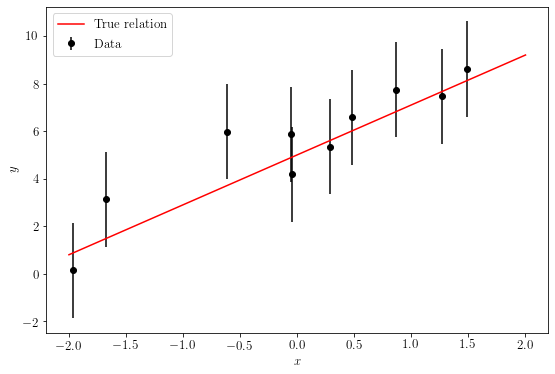

In [3]:
plt.figure(figsize=(9,6))

x_plot = np.linspace(-2.,2.,2)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('$x$', fontsize=FONTSIZE)
plt.ylabel('$y$', fontsize=FONTSIZE)
plt.errorbar(x_data, y_data, 2., fmt='o', color='k', label='Data')
plt.plot(x_plot, slope_true * x_plot + intercept_true, 'r',label='True relation')
plt.legend(fontsize=FONTSIZE)
plt.show()

<font size="3.7">As we discussed in the last seminar, the likelihood for fitting the data, $\{x_i, y_i\}$ is given as,

\begin{equation}
\mathcal{P}(\{x_i\}, \{y_i\}|m, c) = \prod_{i=1}^{N_{\text{points}}}\frac{1}{\sqrt{2\pi}}\exp\bigg(-\frac{(y_i - y^{\text{model}}_i(x_i, m, c))^2}{2}\bigg)
\end{equation}
where, 
\begin{equation}
y^{\text{model}}_i(x_i, m, c)) = m x_i +c
\end{equation}</font>

In [4]:
def ln_prior_regression(theta):
    m, c = theta
    if(np.abs(m) > 10.):
        return -np.inf
    if(np.abs(c) > 20.):
        return -np.inf
    return 0.

def ln_likelihood_regression(theta, x_data, y_data):
    m, c = theta
    y_model = m*x_data + c
    return np.sum(-0.5*(y_model - y_data)**2)

def ln_posterior_regression(theta, x_data, y_data):
    m, c = theta
    return ln_likelihood_regression(theta, x_data, y_data) + ln_prior_regression(theta)

<font size="3.7">Remember that we sampled from the posterior using the Metropolis-Hastings algorithm. The Metropolis-Hastings algorithm is a 'guess and check' algorithm, where you propose new points and then use an accept-reject scheme to sample from the posterior.

The Metropolis-Hastings algorithm consists of the following steps.

- Step 1: Initialize the MCMC chain at a point, $\Theta_0$, in the parameter space.
- Step 2: ($\textit{Proposal}$) Propose a new point, $\Theta_{\textrm{new}}$, from the proposal distribution, $\mathcal{N}(\Theta_0, \sigma_s)$, where, $\Theta_0$ is the current point in the parameter space. $\sigma_s$ is the step size. This is an important hyperparameter in running the MCMC simulations.
- Step 3: ($\textit{Accept-reject scheme}$) Compare the posterior ratios of the proposed point and the current point. 

Sample a point $U \sim \textrm{Unif}(0, 1)$. If $U$ < min$(1,\frac{\mathcal{P}(Θ_{\textrm{new}}|D)}{\mathcal{P}(Θ_0|D)})$, the proposed point is accepted and is set as the next point in the chain. Otherwise, the next point in the chain is set retained as the current point.
- Step 4: Repeat Steps 2 and 3 for $N$ times, where you propose the $(t+1)$-th step, $\Theta_{t+1}$ from $\mathcal{N}(\Theta_t, \sigma_s)$ and accept or reject the new point based on Step 3. This finally yields us a chain of length $N$.

We will not show today that this yields a stationary distribution. Nonetheless, it is easy to show by considering the transition probability.</font>

In [5]:
from samplers.MH import MH_sampler

In [6]:
# Initialize the MH sampler using the log posterior for regression and feeding in the simulated data

regression_mh_sampler = MH_sampler(2, ln_posterior_regression, (x_data, y_data,))

In [7]:
# Initialize the chain at (m,c)=(0,0)
starting_pos = np.array([0.0, 0.0])

# We use step sizes of 0.3 in both directions. 
# We will try to look at the effect of choosing step sizes that are too large or too small.
step_size = 0.3 * np.ones(2)

# Run the sampler for 5000 times
regression_mh_sampler.sample(starting_pos, step_size, 5000)

## How to visually analyze your MCMC run

<font size="3.7">Now that the MCMC run is complete, how should we analyze the run?

Let us formalize a few steps that helps us analyzing the samples that is drawn from the MCMC run. We propose 4 useful visual ways to do this:

- Trace plots
- Animating the samples
- Corner plots
- Posterior predictive plots
</font>

#### Trace plot

<font size="3.7">The output of the completed MCMC run is the Markov Chain for the samples in a multi-dimensional space.

A useful plot is to just plot the Markov chain in all dimensions. This is what is known as the $\textit{Trace plot}$.

The trace plot can tell us about convergence (burn-in), sampler getting stuck, and other such problems.

Let us plot the trace plot for our samplerof linear regression.</font>

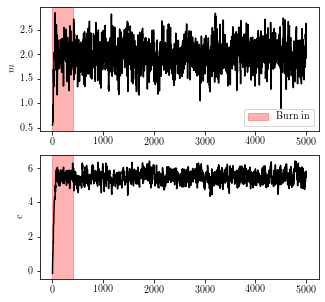

In [8]:
f, ax = plt.subplots(2,1,figsize=(5,5))

ax[0].set_ylabel('$m$')
ax[1].set_ylabel('$c$')
ax[0].plot(regression_mh_sampler.chain.T[0], 'k-')
ax[1].plot(regression_mh_sampler.chain.T[1], 'k-')

for i in range(2):
    ax[i].axvspan(0, 400, color='r', alpha=0.3, label='Burn in')
ax[0].legend()

plt.show()

<font size="3.7">In our trace plot, the burn-in phase is clearly visible. We are being conservative here in discarding the first 400 steps of the Markov Chains. The true burn-in phase is probably less than 100 steps.

#### Corner plots

The second useful visualization is plotting the distribution of the samples (After all, that is the main goal in doing the MCMC run). The easiest way to do it is by plotting the joint 2-dimensional probabilities (by plotting 2D histograms) of all possible parameter combinations, and the marginal probabilities of each dimension. The marginal distribution can be obtained by simply discarding all the dimensions that are not of interest.

Corner plots are useful for determining some useful properties for the inferred distribution, like:
- What is the correlation between different parameters? Is there any degeneracy? Do you expect that degeneracy from physical reasoning? (See the supernovae example)
- What is the shape of the inferred distribution? Is it Gaussian? If not, then what is it and why?
</font>

In [9]:
N_BURN_IN = 400

samples = regression_mh_sampler.chain[N_BURN_IN:]

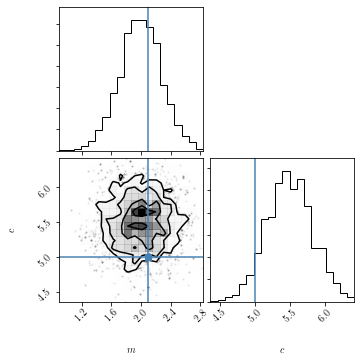

In [10]:
import corner

corner.corner(samples, labels=['$m$', '$c$'],truths=[2.1, 5.])
plt.show()

<font size="3.7">The linear regression example only has 2 parameters. Therefore, only one possible 2-D combination of parameters. 

Here is an example of multidimensional inference from my research consisting of 4-dimensional parameter space.
</font>

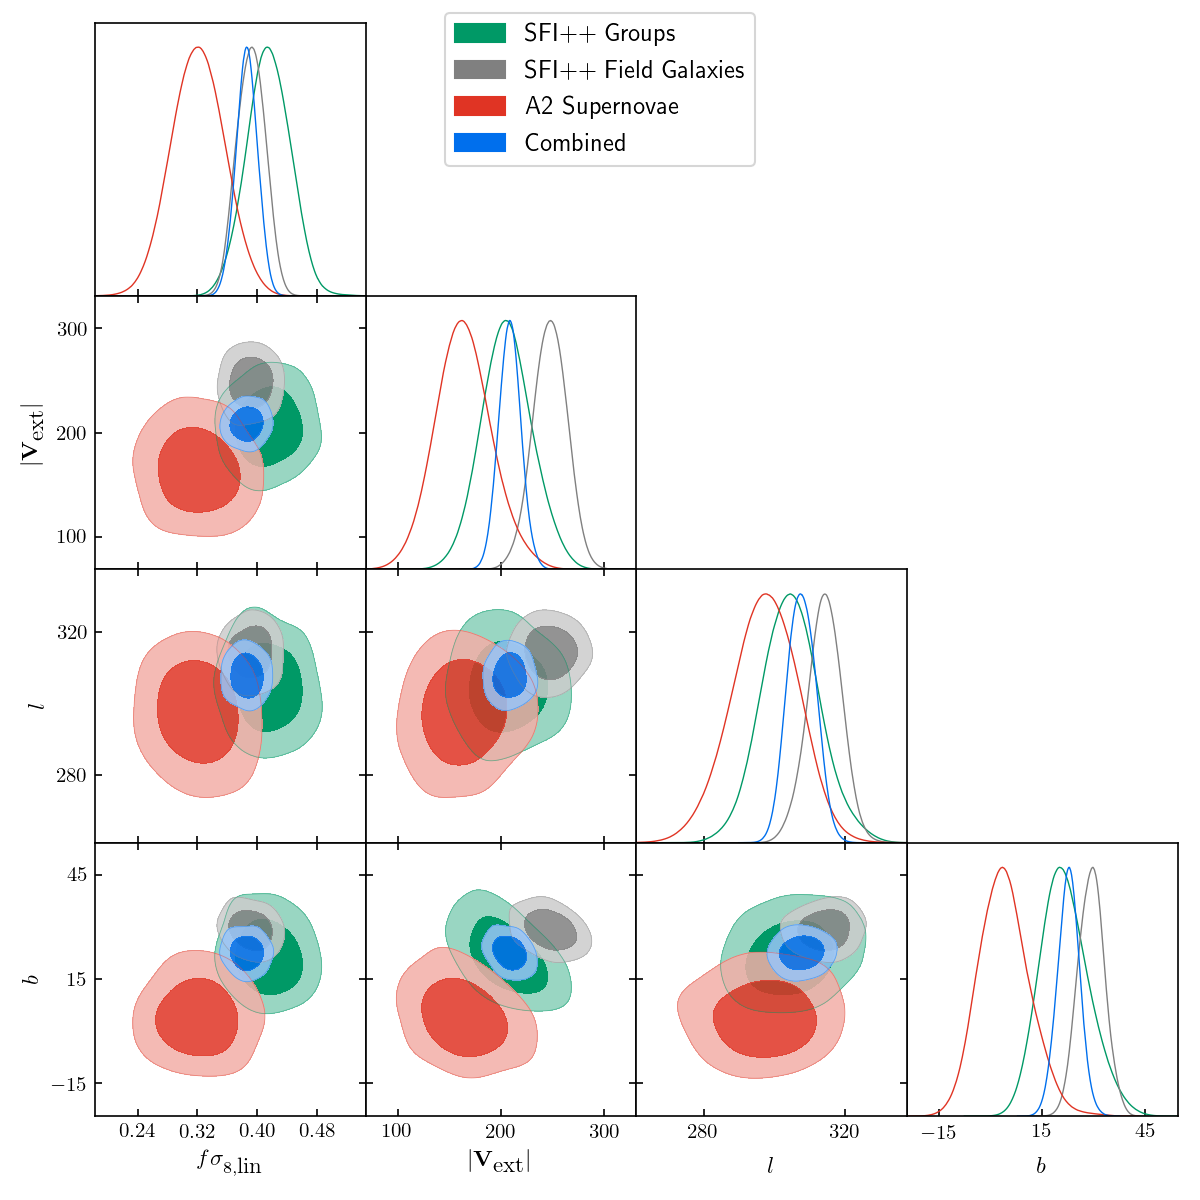

In [11]:
from IPython.display import Image

Image("./corner_example.png",width=600,height=600)

#### Posterior predictive plots

<font size="3.7">What the corner plots tell us is about the underlying parameters. In this case, the slope and the intercept are useful, but it is more interpretable if we plot the inferred relation for a given parameter. Such plots are called the posterior predictive plots. In such plots, we plot some function, $f(\{\theta\})$ of the inferred parameters, $\{\theta\}$. In this case, $f(x,\{m,c\}) = m x + c$.

We propose two ways of plotting this:

- First, calculating the mean and the standard deviation (more accurately, the percentiles) of the inferred relation, $y$ for different samples.
- Second, plot randomly selected points from the samples and then plotting the inferred relation from these samples. 
</font>

In [12]:
# Get the sampled values of the slope and intercept

m_samples, c_samples = samples.T

m_samples = m_samples.reshape((len(m_samples),1))
c_samples = c_samples.reshape((len(c_samples),1))

In [13]:
# Value of y for each of these samples

y_samples = m_samples * x_plot.reshape((1,len(x_plot))) + c_samples

In [14]:
# Get the mean and the error on the inferred relation

y_sample_mean = np.mean(y_samples, axis=0)
y_1sigma_lower = np.percentile(y_samples, 16., axis=0)
y_1sigma_upper = np.percentile(y_samples, 84., axis=0)
y_2sigma_lower = np.percentile(y_samples, 2.5, axis=0)
y_2sigma_upper = np.percentile(y_samples, 97.5, axis=0)

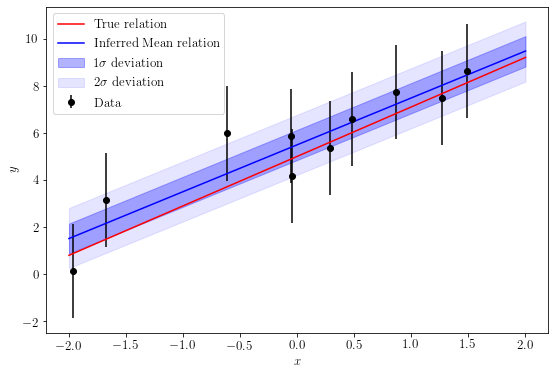

In [15]:
plt.figure(figsize=(9,6))
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('$x$', fontsize=FONTSIZE)
plt.ylabel('$y$', fontsize=FONTSIZE)
plt.errorbar(x_data, y_data, 2., fmt='o', color='k', label='Data')
plt.plot(x_plot, slope_true * x_plot + intercept_true, 'r',label='True relation')
plt.plot(x_plot, y_sample_mean, 'b', label='Inferred Mean relation')
plt.fill_between(x_plot, y_1sigma_lower, y_1sigma_upper, color='b', alpha=0.3, label='$1\sigma$ deviation')
plt.fill_between(x_plot, y_2sigma_lower, y_2sigma_upper, color='b', alpha=0.1, label='$2\sigma$ deviation')
plt.legend(fontsize=FONTSIZE)
plt.show()

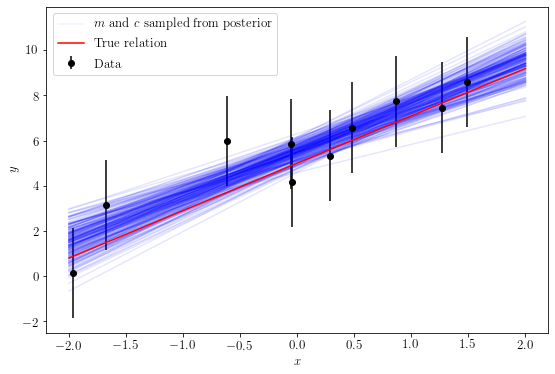

In [16]:
plt.figure(figsize=(9,6))
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('$x$', fontsize=FONTSIZE)
plt.ylabel('$y$', fontsize=FONTSIZE)
for i in range(200):
    ind = np.random.randint(0, y_samples.shape[0])
    if(i==0):
        plt.plot(x_plot, y_samples[ind], 'b', alpha=0.05, label='$m$ and $c$ sampled from posterior')
    plt.plot(x_plot, y_samples[ind], 'b', alpha=0.1)
plt.errorbar(x_data, y_data, 2., fmt='o', color='k', label='Data')
plt.plot(x_plot, slope_true * x_plot + intercept_true, 'r',label='True relation')
plt.legend(fontsize=FONTSIZE)
plt.show()

#### Sample animation

In [17]:
from IPython.display import HTML
HTML('<img src="./burnin_animation.gif">')

## Testing Convergence of the MCMC Chains

<font size="3.7">The analysis tools mentioned in the last section is more qualitative. Let us now try to understand a few quantitative tools to analyze convergence, etc. for the MCMC run. We discuss two such quantities:

- Autocorrelation function of the Markov Chain.
- Gelman-Rubin diagnostic for convergence.

#### Autocorrelation function

The autocorrelation function for a Markov-Chain as a function of $t$ is defined as, 

\begin{equation}
    C(t) = \frac{1}{N_{\textrm{samples}} - t}\sum_{i=1}^{N_{\textrm{samples}-t}}\frac{(\theta_i - \bar{\theta})(\theta_{i+t} - \bar{\theta})}{\sigma^2_{\theta}}\,,
\end{equation}

For sufficiently large $t$, the autocorrelation function should approach $0$.

The faster the autocorrelation function goes to $0$, more $\textbf{independent}$ samples are there in our samples.

The autocorrelation function going to zero is also an indication of convergence for the chains.</font>

In [18]:
def sample_autocorr(x, time_arr):
    """
    Function to compute the autocorrelation of a given sample.
    :param x: Chain of the sample. Must be of the shape (n_dim, n_chain)
    :param time_arr: An array of time arrat for which the auto correlation is calculated
    """
    n_dim = x.shape[1]
    auto_corr_arr = np.zeros((n_dim, len(time_arr)))
    for d in range(n_dim):
        for t in time_arr:
            auto_corr_arr[d,t] = np.corrcoef(np.array(x[:len(x)-t, d]), np.array(x[t:len(x), d]))[0,1]
    return auto_corr_arr

In [19]:
time_arr = np.arange(500)

autocorr_arr = sample_autocorr(regression_mh_sampler.chain, time_arr)

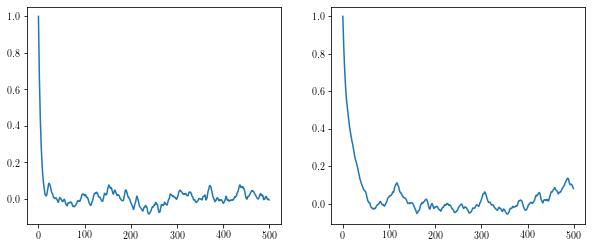

In [20]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
    ax[i].plot(time_arr, autocorr_arr[i])

plt.show()

#### Gelman-Rubin Test

<font size="3.7">Gelman-Rubin test involves running multiple MCMC chains and then comparing the within chain variance and the variance between the chains. If the chain has converged, the two variances should be the same.

The within chain variance at the $i$-th iteration is defined as,

\begin{equation}
W(k) = \frac{1}{m}\sum_{j=1}^{m}s_j^2(k),
\end{equation}

where, 

\begin{equation}
s_j^2(k) = \frac{1}{k-1}\sum_{i=1}^k (\theta^{(i)}_j - \bar{\theta}^{(.)}_j)^2.
\end{equation}

Here, $\bar{\theta}^{(.)}_j$ is the cumulative mean of the $j$-th chain till the $k$-th iteration, i.e.,

\begin{equation}
\bar{\theta}^{(.)}_j = \frac{1}{k}\sum_{i=1}^k \theta^{(i)}_j
\end{equation}

Next, the variance betweeen the chains at the $k$-th iteration is defined as, 

\begin{equation}
B(k) = \frac{k}{m-1}\sum_{j=1}^{m} (\bar{\theta}^{(.)}_j - \bar{\theta}^{(.)}_.)^2.
\end{equation}

Here, $\bar{\theta}^{(.)}_.$ is the cumulative mean after combining all the chains at the $k$-th iteration.

The Rubin-Gelman statistic at the $k$-th iteration is defined as,

\begin{equation}
    \hat{R}(k) = \sqrt{1 + \frac{1}{k}\bigg(\frac{B}{W} - 1\bigg)}
\end{equation}

To check convergence, choose $k$ such that $\hat{R}(k) \approx 1$.
</font>

In [21]:
def run_multiple_chains(ln_posterior, lnposterior_args, step_size, N_SAMPLES=5000, N_CHAINS=10, N_DIM=2):
    chains = []

    for i in range(N_CHAINS):
        print("Running sampler # "+str(i))
        starting_pos = np.random.normal(loc=np.array([2., 5.]), scale=3.*np.ones(2))
        regression_mh_sampler = MH_sampler(N_DIM, ln_posterior, lnposterior_args)
        regression_mh_sampler.sample(starting_pos, step_size, N_SAMPLES)
        chains.append(regression_mh_sampler.chain)
        
    return np.array(chains)

In [22]:
chains_arr = run_multiple_chains(ln_posterior_regression, (x_data, y_data,), 0.3 * np.ones(2))

Running sampler # 0
Running sampler # 1
Running sampler # 2
Running sampler # 3
Running sampler # 4
Running sampler # 5
Running sampler # 6
Running sampler # 7
Running sampler # 8
Running sampler # 9


In [23]:
def gelman_rubin_diagnostics(chains_arr):
    N_CHAINS, N_SAMPLES, N_DIM = chains_arr.shape
    cumulative_mean = np.zeros((N_CHAINS, N_SAMPLES-1, N_DIM))
    R = np.zeros((N_SAMPLES-1, N_DIM))
    
    for i in range(N_SAMPLES-1):
        cumulative_mean[:,i,:] = np.mean(chains_arr[:,:(i+1),:], axis=1)
    
    cumulative_mean_allchains = np.mean(cumulative_mean, axis=0)
    
    for i in range(1,N_SAMPLES-1):
        B = (i+1)/(N_CHAINS - 1) * np.sum((cumulative_mean[:,i] - cumulative_mean_allchains[i])**2, axis=0)
        sj_sq = (1./i) * np.sum((chains_arr[:,:(i+1)] - cumulative_mean[:,i].reshape(N_CHAINS,1,N_DIM))**2, axis=1)
        W = np.mean(sj_sq, axis=0)
        R[i] = (i/(i+1) * W + 1./(i+1) * B)/W
    
    return R

In [24]:
R = gelman_rubin_diagnostics(chains_arr)

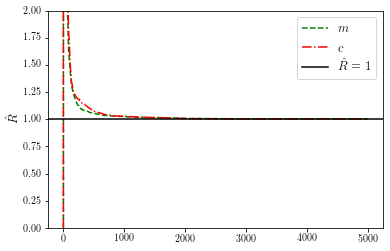

In [25]:
plt.ylim(0., 2.)
plt.ylabel('$\hat{R}$',fontsize=FONTSIZE)
plt.plot(R[:,0], 'g--', label='$m$')
plt.plot(R[:,1], 'r-.', label='$c$')
plt.axhline(1., color='k', label='$\hat{R} = 1$')
plt.legend(fontsize=FONTSIZE)
plt.show()

### Step size and Adaptive MH Sampling

<font size="3.7">Now that we have some of the tools to analyze and check convergence of our Metropolis-Hastings MCMC run, let us look at one of the main issue in using MH sampler. This is the issue of how we choose the step size.

Remember, MH algorithm is a guess-and-check algorithm. By guessing better, we can improve the performance of our MCMC sampler. There is a hyperparameter in our algorithm. That is the step size we use for proposing new points.

Let's start by checking the effect of choosing step sizes that are too small or too large.</font>

In [26]:
# Initialize 3 MH sampler using the log posterior for regression and feeding in the simulated data

regression_mh_sampler_small_step = MH_sampler(2, ln_posterior_regression, (x_data, y_data,))
regression_mh_sampler_medium_step = MH_sampler(2, ln_posterior_regression, (x_data, y_data,))
regression_mh_sampler_large_step = MH_sampler(2, ln_posterior_regression, (x_data, y_data,))

In [27]:
# Initialize all the chain at (m,c)=(0,0)
starting_pos = np.array([0.0, 0.0])

# Use different step sizes for the 3 samplers.
# We will try to look at the effect of choosing step sizes that are too large or too small.
small_step_size = 0.03 * np.ones(2)
medium_step_size = 0.3 * np.ones(2)
large_step_size = 3. * np.ones(2)

# Run each sampler for 5000 times
regression_mh_sampler_small_step.sample(starting_pos, small_step_size, 2000)
regression_mh_sampler_medium_step.sample(starting_pos, medium_step_size, 2000)
regression_mh_sampler_large_step.sample(starting_pos, large_step_size, 2000)

Let us look at the trace plot.

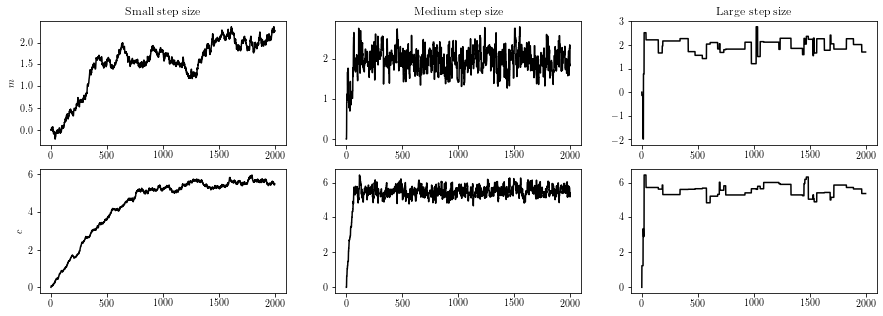

In [28]:
f, ax = plt.subplots(2,3,figsize=(15,5))

ax[0,0].set_title('Small step size')
ax[0,1].set_title('Medium step size')
ax[0,2].set_title('Large step size')

ax[0,0].set_ylabel('$m$')
ax[1,0].set_ylabel('$c$')

ax[0,0].plot(regression_mh_sampler_small_step.chain.T[0], 'k-')
ax[1,0].plot(regression_mh_sampler_small_step.chain.T[1], 'k-')

ax[0,1].plot(regression_mh_sampler_medium_step.chain.T[0], 'k-')
ax[1,1].plot(regression_mh_sampler_medium_step.chain.T[1], 'k-')

ax[0,2].plot(regression_mh_sampler_large_step.chain.T[0], 'k-')
ax[1,2].plot(regression_mh_sampler_large_step.chain.T[1], 'k-')

plt.show()

<font size="3.7">It seems like the sampler with small step size is not exploring everything. At least not as efficiently.It also seems to take a long time to burn-in.

The sampler with large step size on the other hand is getting stuck. Doesn't seem to move much.

Let us look at the acceptance fraction for the three samplers.</font>

In [29]:
print("Acceptance fraction of small step size: %2.3f"%(regression_mh_sampler_small_step.acceptance_fraction))
print("Acceptance fraction of medium step size: %2.3f"%(regression_mh_sampler_medium_step.acceptance_fraction))
print("Acceptance fraction of large step size: %2.3f"%(regression_mh_sampler_large_step.acceptance_fraction))

Acceptance fraction of small step size: 0.888
Acceptance fraction of medium step size: 0.552
Acceptance fraction of large step size: 0.022


<font size="3.7">The small step size has ahuge acceptance rate. The proposed steps are so small that most of the proposal are accepted. On the other hand, with the large step size, very few of the proposals are begin accepted.

Let's look at the autocorrelation function for the three samplers.</font>

In [30]:
time_arr = np.arange(1000)

autocorr_arr_small_step  = sample_autocorr(regression_mh_sampler_small_step.chain, time_arr)
autocorr_arr_medium_step = sample_autocorr(regression_mh_sampler_medium_step.chain, time_arr)
autocorr_arr_large_step  = sample_autocorr(regression_mh_sampler_large_step.chain, time_arr)

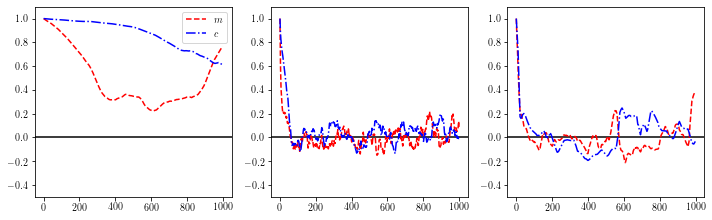

In [31]:
fig, ax = plt.subplots(1,3,figsize=(12,3.5))

colors = ['r--', 'b-.']
labels = ['$m$', '$c$']

for i in range(3):
    ax[i].set_ylim(-0.5, 1.1)
    ax[i].axhline(0.0, color='k')
    
for i in range(2):
    ax[0].plot(autocorr_arr_small_step[i], colors[i], label=labels[i])
    ax[1].plot(autocorr_arr_medium_step[i], colors[i])
    ax[2].plot(autocorr_arr_large_step[i], colors[i])
ax[0].legend()
plt.show()

Let's also look at the Rubin-Gelman statistics.

In [32]:
chains_arr_big_step = run_multiple_chains(ln_posterior_regression, (x_data, y_data,), 3. * np.ones(2))
chains_arr_small_step = run_multiple_chains(ln_posterior_regression, (x_data, y_data,), 0.03 * np.ones(2))

Running sampler # 0
Running sampler # 1
Running sampler # 2
Running sampler # 3
Running sampler # 4
Running sampler # 5
Running sampler # 6
Running sampler # 7
Running sampler # 8
Running sampler # 9
Running sampler # 0
Running sampler # 1
Running sampler # 2
Running sampler # 3
Running sampler # 4
Running sampler # 5
Running sampler # 6
Running sampler # 7
Running sampler # 8
Running sampler # 9


In [33]:
R_big_step = gelman_rubin_diagnostics(chains_arr_big_step)
R_small_step = gelman_rubin_diagnostics(chains_arr_small_step)

/Users/boruah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


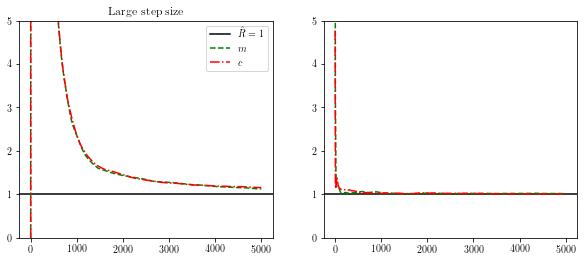

In [34]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
    ax[i].set_ylim(0., 5.)
    ax[i].axhline(1., color='k', label='$\hat{R} = 1$')

ax[0].set_title('Small step size')
ax[0].plot(R_small_step[:,0], 'g--', label='$m$')
ax[0].plot(R_small_step[:,1], 'r-.', label='$c$')
ax[0].legend()

ax[0].set_title('Large step size')
ax[1].plot(R_big_step[:,0], 'g--')
ax[1].plot(R_big_step[:,1], 'r-.')

plt.show()

#### Why is the medium step size performing so much better?

In [35]:
samples = regression_mh_sampler_medium_step.chain[500:]

sample_mean = np.mean(samples, axis=0)
sample_std  = np.std(samples, axis=0)

print("The standard deviation in the samples (for m and c) is : %2.2f and %2.2f"%(sample_std[0], sample_std[1]))

The standard deviation in the samples (for m and c) is : 0.27 and 0.29


<font size="3.7">A rule of thumb: If the proposal distribution has the same width (standard deviation) as the posterior, we get better sampling. With this in mind, let us move to and adaptive version of the MH algorithm.
    
### Adaptive Metropolis-Hastings Sampler

We saw the problem that arises because of choosing step sizes that are too small or too large. We saw that the optimal choice for the step size is the covariance of the posterior. 

Therefore, we design an Adaptive Metropolis-Hastings algorithm which learns the covariance matrix from the samples. In this algorithm, there is a phase of '$\textit{covariance learning}$', where the step size is adapted by calculating the standard deviation of the samples. 

That is, the step size, $\sigma_s$, at the $i$-th iteration is computed as,

\begin{equation}
\sigma^2_s(i) = \frac{1}{i - N_{\textrm{start}}}\sum_{j=N_{\textrm{start}}}^{i}(\theta^{(j)} - \bar{\theta}^{(.)})^2
\end{equation}

Note that changing the covariance amidst the run violates detailed balance, i.e, for the phase of the covariance larning, the sampler is no longer sampling from a stationary distribution. Therefore, we have to discard the samples of the covariance learning phase.

Let us now sample with the same step sizes as before, but let us also introduce the covariance learning phase. 
</font>    

In [36]:
from samplers.AdaptiveMH import Adaptive_MH_sampler

In [37]:
# Initialize the MH sampler using the log posterior for regression and feeding in the simulated data

regression_adaptive_mh_sampler_small_step = Adaptive_MH_sampler(2, ln_posterior_regression, (x_data, y_data,))
regression_adaptive_mh_sampler_medium_step = Adaptive_MH_sampler(2, ln_posterior_regression, (x_data, y_data,))
regression_adaptive_mh_sampler_large_step = Adaptive_MH_sampler(2, ln_posterior_regression, (x_data, y_data,))

In [38]:
# Initialize the chain at (m,c)=(0,0)
starting_pos = np.array([0.0, 0.0])

# We use different step sizes.
# We will try to look at the effect of choosing step sizes that are too large or too small.
small_step_size = 0.03 * np.ones(2)
medium_step_size = 0.3 * np.ones(2)
large_step_size = 3. * np.ones(2)

N_START = 1000
N_LEARN = 1000

# Run the sampler for 5000 times
regression_adaptive_mh_sampler_small_step.sample(starting_pos, small_step_size, 5000, N_START=N_START, N_LEARN=N_LEARN)
regression_adaptive_mh_sampler_medium_step.sample(starting_pos, medium_step_size, 5000, N_START=N_START, N_LEARN=N_LEARN)
regression_adaptive_mh_sampler_large_step.sample(starting_pos, large_step_size, 5000, N_START=N_START, N_LEARN=N_LEARN)

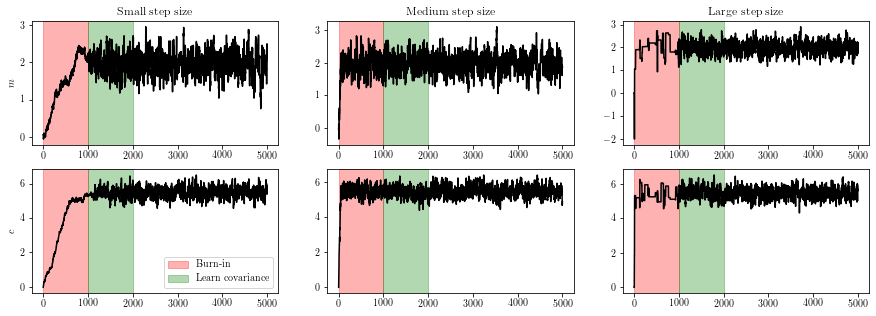

In [39]:
f, ax = plt.subplots(2,3,figsize=(15,5))

ax[0,0].set_title('Small step size')
ax[0,1].set_title('Medium step size')
ax[0,2].set_title('Large step size')

ax[0,0].set_ylabel('$m$')
ax[1,0].set_ylabel('$c$')

for i in range(2):
    for j in range(3):
        ax[i,j].axvspan(0.,1000, color='r',alpha=0.3,label='Burn-in')
        ax[i,j].axvspan(1000,2000, color='g',alpha=0.3,label='Learn covariance')
        
ax[0,0].plot(regression_adaptive_mh_sampler_small_step.chain.T[0], 'k-')
ax[1,0].plot(regression_adaptive_mh_sampler_small_step.chain.T[1], 'k-')

ax[0,1].plot(regression_adaptive_mh_sampler_medium_step.chain.T[0], 'k-')
ax[1,1].plot(regression_adaptive_mh_sampler_medium_step.chain.T[1], 'k-')

ax[0,2].plot(regression_adaptive_mh_sampler_large_step.chain.T[0], 'k-')
ax[1,2].plot(regression_adaptive_mh_sampler_large_step.chain.T[1], 'k-')

ax[1,0].legend()

plt.show()

As you can see, even with the small or large step sizes, during the phase of covariance learning the sampler ends up adapting to an optimal step size.

In [40]:
print("Acceptance fraction of small step size: %2.3f"%(regression_adaptive_mh_sampler_small_step.acceptance_fraction))
print("Acceptance fraction of medium step size: %2.3f"%(regression_adaptive_mh_sampler_medium_step.acceptance_fraction))
print("Acceptance fraction of large step size: %2.3f"%(regression_adaptive_mh_sampler_large_step.acceptance_fraction))

Acceptance fraction of small step size: 0.637
Acceptance fraction of medium step size: 0.571
Acceptance fraction of large step size: 0.421


The acceptance fraction is also now intermediate, not too large, nor too small.

In [41]:
samples = regression_adaptive_mh_sampler_medium_step.chain[2000:]

sample_std = np.std(samples, axis=0)

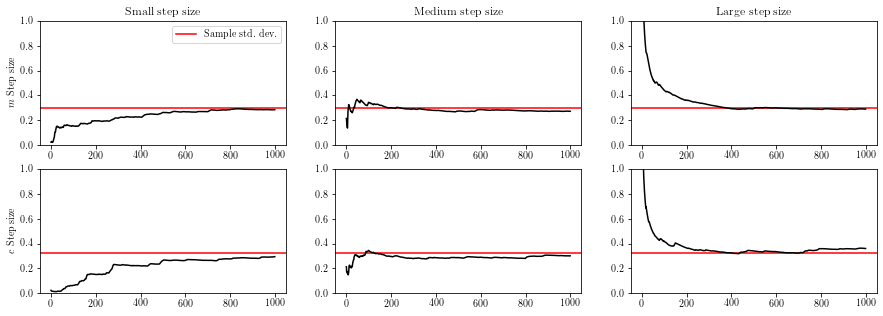

In [42]:
# Comparing the learned step sizes to the sample standard deviation

f, ax = plt.subplots(2,3,figsize=(15,5))

ax[0,0].set_title('Small step size')
ax[0,1].set_title('Medium step size')
ax[0,2].set_title('Large step size')

ax[0,0].set_ylabel('$m$ Step size')
ax[1,0].set_ylabel('$c$ Step size')

for i in range(3):
    ax[0,i].axhline(sample_std[0], color='r', label='Sample std. dev.')
    ax[1,i].axhline(sample_std[1], color='r', label='Sample std. dev.')
    ax[0,i].set_ylim(0.,1.0)
    ax[1,i].set_ylim(0.,1.0)
    if(i==0):
        ax[0,i].legend()
    
ax[0,0].plot(regression_adaptive_mh_sampler_small_step.learned_step_size[0], 'k-')
ax[1,0].plot(regression_adaptive_mh_sampler_small_step.learned_step_size[1], 'k-')

ax[0,1].plot(regression_adaptive_mh_sampler_medium_step.learned_step_size[0], 'k-')
ax[1,1].plot(regression_adaptive_mh_sampler_medium_step.learned_step_size[1], 'k-')

ax[0,2].plot(regression_adaptive_mh_sampler_large_step.learned_step_size[0], 'k-')
ax[1,2].plot(regression_adaptive_mh_sampler_large_step.learned_step_size[1], 'k-')

plt.show()

### Extra Material : Discovering Dark Energy

##### Modelling the predictions

<font size="3.7">Astrophysicists like to use a logarithmic quantity called the distance modulus to quantify distance. The quantity, $d_L$ is known as a luminosity distance. Because of general relativistic effect, distance measurements in an expanding Universe is tricky. $z$ is called the redshift, which can be thought of as arising because of Doppler shift in an expanding Universe. The distance measurements depend on the amount of matter, $\Omega_m$ and the amount od dark energy, or vacuum energy, $\Omega_{\Lambda}$. The more matter you have, stronger the gravity, thus slowing down the expansion of the Universe. The more dark energy you have, stronger the "anti-gravity", thus speeding up the expansion of the Universe.  

Supernovae, which are dying stars, almost 'standard candles', i.e., they have a almost constant intrinsic brightness. Therefore, by measuring the brightness (measured by the apparent magnitude, $m$) and the redshift, we can infer the distance vs redshift relationship.

The exact dependence of the distance measurement as a function of $\Omega_m$ and $\Omega_{\Lambda}$ is beyond the scope of this course. We will not derive these complicated formula, but I would recommend the book $\textit{Spacetime and Geometry: An Introduction to General Relativity}$ by Sean Carroll for the interested readers. 

\begin{equation}
\mu^{\textrm{pred}}(z, \Omega_m, \Omega_{\Lambda}) = 25 + 5 \log_{10}\bigg[\frac{d_L(z, \Omega_m, \Omega_{\Lambda}, h)}{1 \textrm{Mpc}} \bigg],
\end{equation}
where,
\begin{equation}
d_L(z, \Omega_m, \Omega_{\Lambda}, h) = \frac{c}{100 h}(1 + z) f(x, \Omega_K)
\end{equation}

\begin{equation}
x = \int_{0}^{z}d z^{\prime} \frac{1}{\sqrt{\Omega_{\Lambda} + \Omega_m (1 + z^{\prime})^3 + \Omega_K (1 + z^{\prime})^2}}
\end{equation}

and

\begin{align}
f(x, \Omega_K) &= x, \quad \textrm{if} ~\Omega_K = 0\\
&= \frac{\sin\big(\sqrt{|\Omega_K|} x\big)}{\sqrt{|\Omega_K|}}, \quad \textrm{if} ~\Omega_K > 0\\
&= \frac{\sinh\big(\sqrt{|\Omega_K|} x\big)}{\sqrt{|\Omega_K|}}, \quad \textrm{if} ~\Omega_K < 0
\end{align}

The apparent magnitude, $m$, which is dependent on the brightness of the suepernova is related to the distance modulus as, 

\begin{equation}
m = M_0 + \mu,
\end{equation}

where, $M_0$ is the intrinsic brightness of the supernova. 

There is an intrinsic scatter in the distance-redshift relation, quatified by $\sigma_{\textrm{int}}$.

The likelihood for the observed supernova 

\begin{equation}
\mathcal{L}(\{z\}, \{m\}|\Omega_m, \Omega_{\Lambda}) = \prod_{i=1}^{N_{\textrm{SN}}}\frac{1}{\sqrt{2\pi\sigma^2_{\textrm{int}}}}\exp \bigg(-\frac{(\mu^{\textrm{pred}}(z_i, \Omega_m, \Omega_{\Lambda}) - m_i + M_0)^2}{2 \sigma^2_{\textrm{int}}} \bigg)
\end{equation}


We use a publicly available simulated set of supernovae from Roberto Trotta's $\textit{"Bayesian Methods in Cosmology"}$ (arXiV:1701.01467). It is simulated with $M_0 = -19.3$, $h=0.72$ and $\sigma_{\textrm{int}}=0.40$.

In our inference, we treat these parameters as being known and fix them to these values.
</font>

In [43]:
# Read the SN data

SN_data = np.loadtxt('SNIa_SimulatedData.txt')
z_data, m_data = SN_data.T

In [44]:
from scipy.integrate import quad
from math import sqrt
speed_of_light = 299972

def integrand(z, cosmo_pars):
    OmegaM, OmegaL = cosmo_pars
    OmegaK = 1. - OmegaM - OmegaL
    return 1./sqrt(OmegaL + OmegaM * (1. + z)**3 + OmegaK * (1. + z)**2)

def luminosity_distance(z, pars):
    h, OmegaM, OmegaL = pars
    OmegaK = 1. - OmegaM - OmegaL
    if(abs(OmegaK) < 1e-4):
        return speed_of_light * (1. + z) * quad(integrand, 0, z, args=([OmegaM, OmegaL],))[0] / 100. / h
    else:
        x = sqrt(abs(OmegaK)) * quad(integrand, 0, z, args=([OmegaM, OmegaL],))[0]
        if(OmegaK < 0.):
            y = np.sin(x) 
        else:
            y = np.sinh(x)
        return speed_of_light * (1. + z) * y / 100. / h / sqrt(abs(OmegaK))

def mu(z, pars):
    dL = luminosity_distance(z, pars)
    return 5 * np.log10(dL) + 25.

In [45]:
z_arr = np.linspace(0.01, 1.4, 200)
mu_arr = np.zeros(len(z_arr))

for i, z in enumerate(z_arr):
    mu_arr[i] = mu(z, [0.72, 0.3, 0.7])

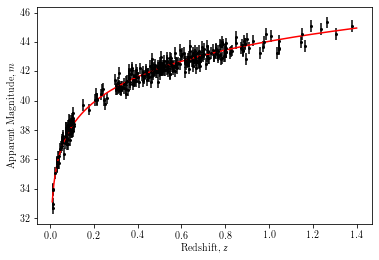

In [46]:
plt.xlabel('Redshift, $z$')
plt.ylabel('Apparent Magnitude, $m$')
plt.errorbar(z_data, m_data + 19.3, 0.4, color='k', fmt='o', markersize=2.)
plt.plot(z_arr, mu_arr, 'r')
plt.show()

In [47]:
def SN_lnprior(theta):
    OmegaM, OmegaL = theta
    if (OmegaM < 0.0) | (OmegaM > 0.98):
        return -np.inf
    return 0.
       
def SN_lnlikelihood(theta, data, h=0.72, M0=-19.3, sigma_int=0.4):
    OmegaM, OmegaL = theta
    z_data, m_data = data
    mu_pred = np.zeros(len(z_data))
    for i, z in enumerate(z_data):
        mu_pred[i] = mu(z, [h, OmegaM, OmegaL])
    mu_data = m_data - M0
    return np.sum(-0.5 * (mu_data - mu_pred)**2/sigma_int**2)
       
def SN_lnposterior(theta, data, h=0.72, M0=-19.3, sigma_int=0.4):
    try:
        return SN_lnlikelihood(theta, data, h, M0, sigma_int) + SN_lnprior(theta)
    except:
        return -np.inf

In [48]:
sn_mh_sampler = MH_sampler(2, SN_lnposterior, (SN_data.T,))

In [49]:
%%time

# Initialize the chain at (OmegaM,OmegaL)=(0.1,0.1)
starting_pos = np.array([0.1, 0.1])

# We use step sizes of 0.05 in both directions. 
# We will try to look at the effect of choosing step sizes that are too large or too small.
step_size = np.array([0.05, 0.05])

# Run the sampler for 10000 times
sn_mh_sampler.sample(starting_pos, step_size, 10000)

CPU times: user 6min 2s, sys: 5.54 s, total: 6min 7s
Wall time: 6min 14s


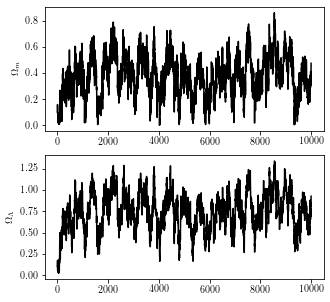

In [50]:
f, ax = plt.subplots(2,1,figsize=(5,5))

ax[0].set_ylabel('$\Omega_m$')
ax[1].set_ylabel('$\Omega_{\Lambda}$')
ax[0].plot(sn_mh_sampler.chain.T[0], 'k-')
ax[1].plot(sn_mh_sampler.chain.T[1], 'k-')

plt.show()

In [51]:
sn_samples = sn_mh_sampler.chain[1000:]

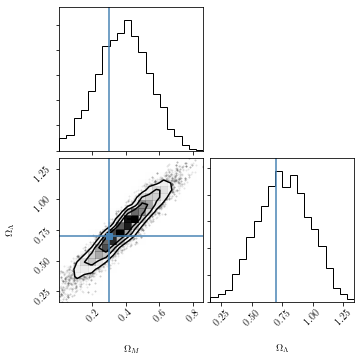

In [52]:
corner.corner(sn_samples, labels=['$\Omega_M$', '$\Omega_{\Lambda}$'],truths=[0.3, 0.7])
plt.show()

In [53]:
sn_sample_mean = np.mean(sn_samples, axis=0)
sn_sample_std  = np.std(sn_samples, axis=0)

print("OmegaM: %2.2f +/- %2.2f"%(sn_sample_mean[0], sn_sample_std[0]))
print("OmegaL: %2.2f +/- %2.2f"%(sn_sample_mean[1], sn_sample_std[1]))

OmegaM: 0.38 +/- 0.15
OmegaL: 0.76 +/- 0.21
